In [133]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches


In [134]:
class DataLoader:
    def __init__(self, file_name: str):
        # Data folder
        data_folder = "../data"
        # Create data folder, if it does not exist
        os.makedirs(data_folder, exist_ok=True)
        # Create file path
        file = os.path.join(data_folder, file_name)
        self.data = pd.read_csv(file)
        # Separate the datapoints to forecast from those used for the training
        self.forecast_data = self.data.iloc[[0, 1, 2, 3, 4, 50, 51, 52, 53, 54, 100, 101, 102, 103, 104]]
        self.train_data = self.data.drop(self.data.index[[0, 1, 2, 3, 4, 50, 51, 52, 53, 54, 100, 101, 102, 103, 104]])
        self.train_data = self.train_data.reset_index()
        # Convert and save the labels of the training flowers as an array of integers for future use
        self.species_train = pd.Categorical(self.train_data['Species']).codes
        # Keep only the useful numerical data, deleting everything else
        self.train_data = self.train_data.drop(columns=['index', 'Id', 'Species'], axis=1)
        # Implement MinMax scaling
        scaling_denominator = (self.train_data.max() - self.train_data.min())
        min_train_data = self.train_data.min()
        self.train_data = (self.train_data - min_train_data) / scaling_denominator
        # Put back the missing column
        self.forecast_data = self.forecast_data.reset_index()
        # Convert and save the labels of the to-be-forecasted-flowers as an array of integers for future use
        self.species_forecast = pd.Categorical(self.forecast_data['Species']).codes
        # Keep only the useful numerical data, deleting everything else
        self.forecast_data = self.forecast_data.drop(columns=['index', 'Id', 'Species'], axis=1)
        # Implement MinMax scaling
        self.forecast_data = (self.forecast_data - min_train_data) / scaling_denominator

Load the dataset and separate it into two groups: the training group and the to-be-forecasted group.

In [135]:
df = DataLoader(file_name='Iris.csv')
print(df.forecast_data.head())
print('\n')
print(df.train_data.head())

   SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm
0       0.222222      0.625000       0.067797      0.041667
1       0.166667      0.416667       0.067797      0.041667
2       0.111111      0.500000       0.050847      0.041667
3       0.083333      0.458333       0.084746      0.041667
4       0.194444      0.666667       0.067797      0.041667


   SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm
0       0.305556      0.791667       0.118644      0.125000
1       0.083333      0.583333       0.067797      0.083333
2       0.194444      0.583333       0.084746      0.041667
3       0.027778      0.375000       0.067797      0.041667
4       0.166667      0.458333       0.084746      0.000000


Initialize a grid for the projection (of shape 8 x 8 x 4).

In [136]:
from som import Grid

som_width = 8
som_length = 8
dimension = 4
grid = Grid(width=som_width, length=som_length, dim=dimension)

Calculate the projections of the to-be-forecasted data onto the untrained (randomly initialized) map.
Save the resulting positions on the map (with the additions of the labels) into a new dataframe named forecast_df.

In [137]:
bmu_positions = []
for row in range(len(df.forecast_data)):
    bmu, bmu_position = grid.bmu_calculator(inputvector=df.forecast_data.iloc[row, :])
    bmu_positions.append(bmu_position)
forecast_df = df.forecast_data.copy()
forecast_df['Species'] = df.species_forecast
forecast_df['bmu_positions'] = bmu_positions

Plot the initialized map visualizing the initial projections of the sample data on top of the nodes.

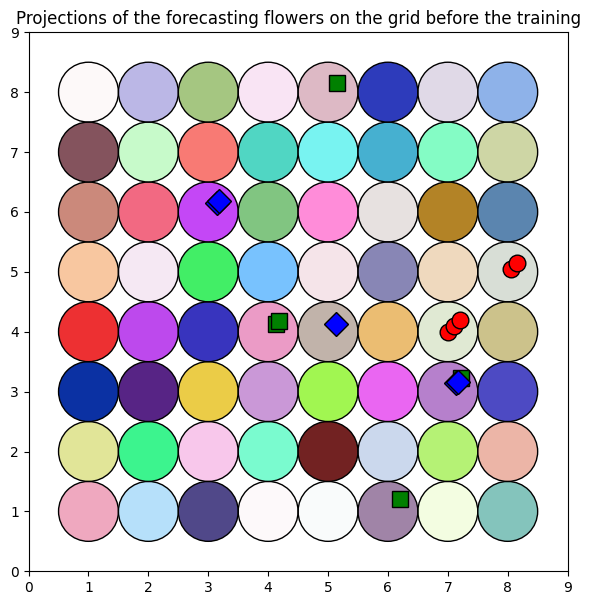

In [138]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
ax.set_xlim((0, grid.width + 1))
ax.set_ylim((0, grid.length + 1))
ax.set_title('Projections of the forecasting flowers on the grid before the training')

for x in range(1, grid.width + 1):
    for y in range(1, grid.length + 1):
        ax.add_patch(patches.Circle((x, y), 0.5, facecolor=grid.nodes[x - 1, y - 1, :], edgecolor='black'))

markers = ['o', 's', 'D']
colors = ['r', 'g', 'b']
for row in range(len(forecast_df)):
    if forecast_df.iloc[row, 4] == 0:  # When the label of the datapoint is 'Iris-setosa'
        plt.plot(forecast_df.iloc[row, 5][0] + 1 + row/20, forecast_df.iloc[row, 5][1] + 1 + row/20,
                         markers[0],
                         markersize=12,
                         markerfacecolor=colors[0],
                         markeredgecolor='k')
    elif forecast_df.iloc[row, 4] == 1:
        plt.plot(forecast_df.iloc[row, 5][0] + 1 + row/40, forecast_df.iloc[row, 5][1] + 1 + row/40,
                         markers[1],
                         markersize=12,
                         markerfacecolor=colors[1],
                         markeredgecolor='k')
    else:
        plt.plot(forecast_df.iloc[row, 5][0] + 1 + row/80, forecast_df.iloc[row, 5][1] + 1 + row/80,
                         markers[2],
                         markersize=12,
                         markerfacecolor=colors[2],
                         markeredgecolor='k')


plt.show()

Train the SOM with the data from the training datagroup.

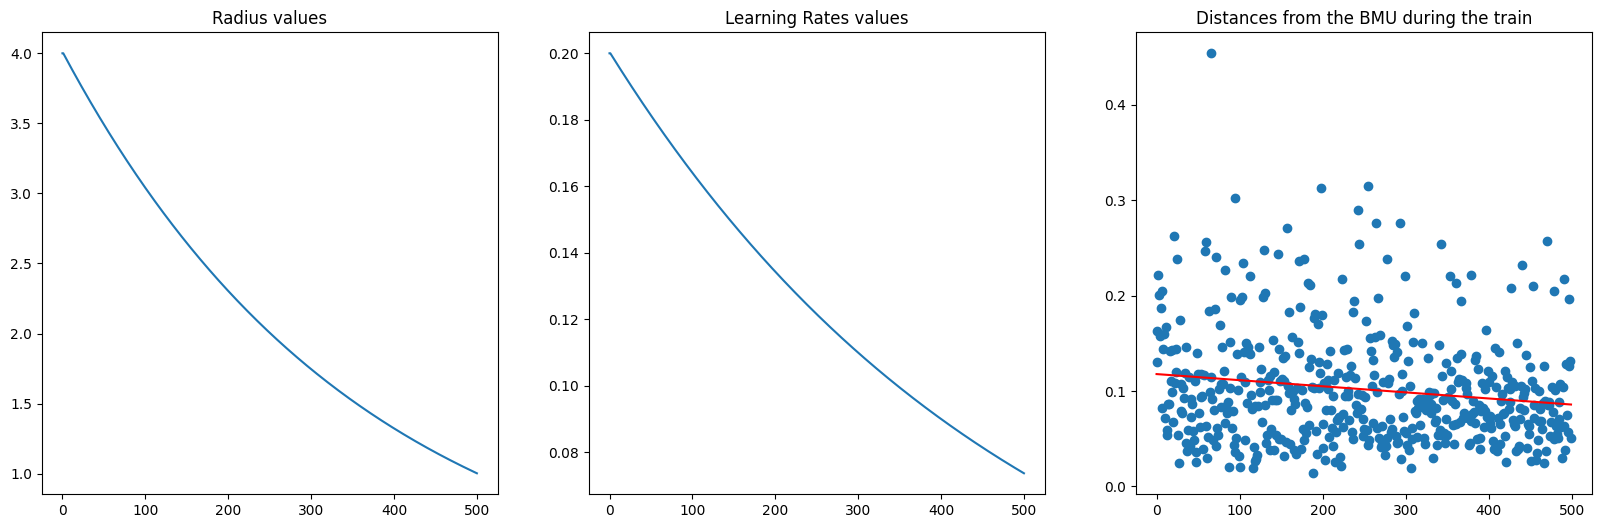

In [139]:
learning_rate_0 = 0.2
iterations = 500
grid.train_som(training_sample=df.train_data, learn_rate=learning_rate_0, epochs=iterations)

Calculate the projections of the to-be-forecasted data onto the trained map.
Save the resulting positions on the map (with the additions of the labels) into a new dataframe named forecast_df.

In [140]:
bmu_positions = []
for row in range(len(df.forecast_data)):
    bmu, bmu_position = grid.bmu_calculator(inputvector=df.forecast_data.iloc[row, :])
    bmu_positions.append(bmu_position)
forecast_df = df.forecast_data.copy()
forecast_df['Species'] = df.species_forecast
forecast_df['bmu_positions'] = bmu_positions

Plot the trained map visualizing the newly calculated projections of the sample data on top of the nodes.

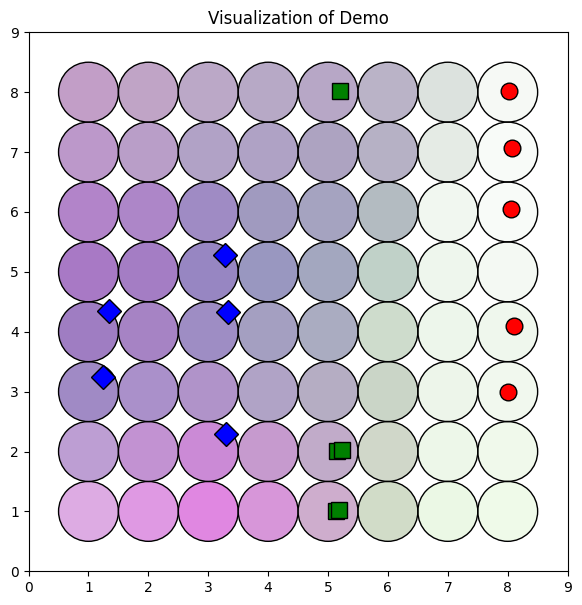

In [141]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
ax.set_xlim((0, grid.width + 1))
ax.set_ylim((0, grid.length + 1))
ax.set_title('Visualization of Demo')

for x in range(1, grid.width + 1):
    for y in range(1, grid.length + 1):
        ax.add_patch(patches.Circle((x, y), 0.5, facecolor=grid.nodes[x - 1, y - 1, :], edgecolor='black'))

markers = ['o', 's', 'D']
colors = ['r', 'g', 'b']
for row in range(len(forecast_df)):
    if forecast_df.iloc[row, 4] == 0:  # When the label of the datapoint is 'Iris-setosa'
        plt.plot(forecast_df.iloc[row, 5][0] + 1 + row/40, forecast_df.iloc[row, 5][1] + 1 + row/40,
                         markers[0],
                         markersize=12,
                         markerfacecolor=colors[0],
                         markeredgecolor='k')
    elif forecast_df.iloc[row, 4] == 1:
        plt.plot(forecast_df.iloc[row, 5][0] + 1 + row/40, forecast_df.iloc[row, 5][1] + 1 + row/400,
                         markers[1],
                         markersize=12,
                         markerfacecolor=colors[1],
                         markeredgecolor='k')
    else:
        plt.plot(forecast_df.iloc[row, 5][0] + 1 + row/40, forecast_df.iloc[row, 5][1] + 1 + row/40,
                         markers[2],
                         markersize=12,
                         markerfacecolor=colors[2],
                         markeredgecolor='k')


plt.show()

Visualize the projections of the training data on the U-matrix.
The projection of the forecast-data seems to be in order.

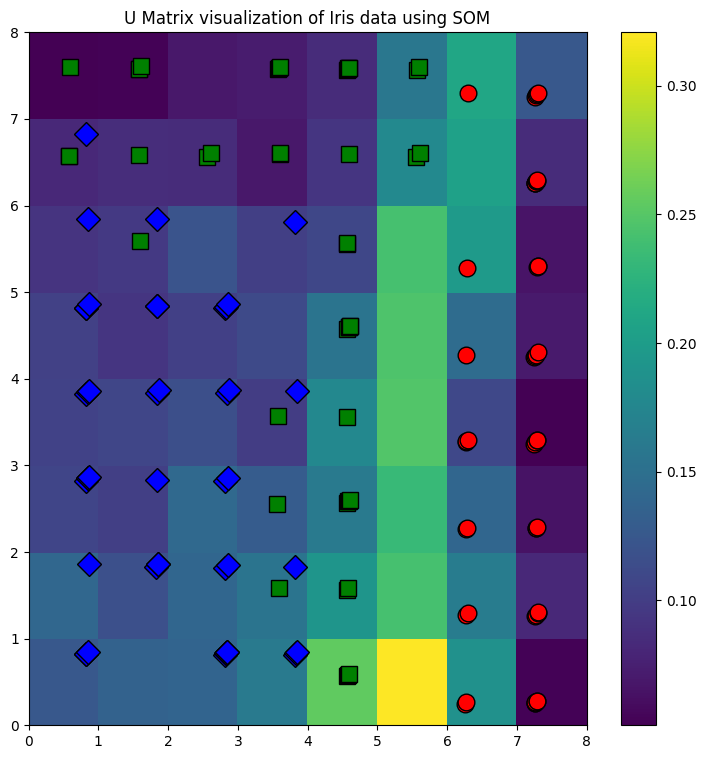

In [143]:
training_df = df.train_data
training_df['Species'] = df.species_train
grid.visualize_flowers(data=training_df)